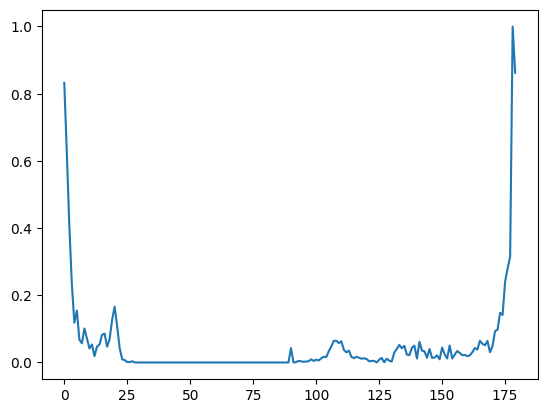

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

plt.ion()


def clear():
    # replace 'cls' with 'clear' if running on Linux/Mac
    return os.system('clear')


def calc_center_of_gravity(P):
    x, y = np.meshgrid(np.arange(P.shape[1]), np.arange(P.shape[0]))
    x_t = np.sum(x * P) / np.sum(P)
    y_t = np.sum(y * P) / np.sum(P)
    return x_t, y_t


def calc_hist_and_normalize(hue):
    # Calculate the histogram of the hue component of the image and normalize it
    hist = cv2.calcHist([hue], [0], None, [180], [0, 180])
    hist = cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)
    plt.plot(hist)
    return hist


clear()
plt.close('all')

# Read in the image of the object to be tracked
image = cv2.imread('cv02_vzor_hrnecek.bmp')
# width, height
height, width = image.shape[:2]

# Převedení obrázku na HSV barevný prostor a výběr hue složky
hue = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)[:, :, 0]

# Výpočet histogramu oblasti
hist = calc_hist_and_normalize(hue)

# zpětná projekce obrazu na histogram
P = cv2.calcBackProject([hue], [0], hist, [0, 180], 1)

# výpočet těžiště obrazu
x_t, y_t = calc_center_of_gravity(P)

s = 0.7 * np.sqrt(np.sum(P))
v = 0.9 * np.sqrt(np.sum(P))

# Open video where the object is to be tracked
cap = cv2.VideoCapture('cv02_hrnecek.mp4')

while True:
    # Read a frame from the video
    ret, bgr = cap.read()
    if not ret:
        break

    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    hue = hsv[:, :, 0]

    # výběr oblasti z následujícího obrázku snímku dle předchozího těžiště
    # roi =bgr[y:y+h, x:x+w]
    y = int(v)
    yh = int(v + height)
    x = int(s)
    xw = int(s + width)
    roi = hsv[y:yh, x:xw]

    roi_hue = roi[:, :, 0]
    # zpětná projekce histogramu na roi
    P = cv2.calcBackProject([hue], [0], hist, [0, 180], 1)
    
    x_t, y_t = calc_center_of_gravity(P)
    
    s = 0.7 * np.sqrt(np.sum(P))
    v = 0.9 * np.sqrt(np.sum(P))

    cv2.rectangle(bgr, (int(x_t - s), int(y_t - v)),
                  (int(x_t + s), int(y_t + v)), (0, 255, 0), 2)

    cv2.imshow('Image', bgr)
    
        # výpočet těžiště obrazu
    

    key = 0xFF & cv2.waitKey(30)
    if key == 27:
        break

cv2.destroyAllWindows()
